## Roll number: 2023122002


### Instructions
 * Fill in the roll-number in the cell above.
 * Code must be submitted in Python in jupyter notebooks. We highly recommend using anaconda/miniconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * For this assignment, you will be using Open3D  extensively. Refer to [Open3D](http://www.open3d.org/docs/release/) documentation.
 *  Most of the questions require you to **code your own functions** unless there is a need to call in the abilities of the mentioned libraries, such as Visualisation from Open3D. Make sure your code is modular since you will be reusing them for future assignments. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 *  All the representations are expected to be in a right-hand coordinate system.
<!--  * Answer to the descriptive questions should be answered in your own words. Copy-paste answers will lead to penalty. -->
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit the notebooks in the repo and any other results files under the result folder in the GitHub Classroom repo. 
 * Commits past the deadline will not be considered.
 * This is a group assignment. Discussions are encouraged but any sharing of code among different teams will be penalized. 

### Instructions for group formation
 * We have circulated google sheet in moodle to fill in team members. Please finalize the teams formation by 18th Aug (tentative deadline). Same teams will be working towards project and other 2 Assignments as well. 
 


# Q1: Transformations and Projections on Autonomous Driving Dataset (20 Points)

In this question, you will work with real world autonomous driving dataset (sequence in Waymo dataset). The dataset has LiDAR point clouds, images. You are required to demonstrate: 

**I. Various transformations of rotation matrices as described in below tasks.**

**II. Visualization as a result of above transformations in Open3D**

## Given data:

1.) `LiDAR Point Clouds` : Stored at each timestep in the folder `lidar`. The point clouds are provided in the ego frame attached to lidar sensor (vehicle's reference frame).

2.) `Images` : Stored at each timestep in the folder `images`. 

**Naming Convention** : {timestep}_{cam_no}.jpg where timestep is specified in 3 digits and cam_no : [0, 1, 2] indicates centre, left and right camera respectively.

3.) `Camera-to-Ego Transformations`: Stored in the folder `cam2ego`, which converts points from each camera's reference frame to the vehicle's (or ego) reference frame.

4.) `Ego-to-World Transformations`: Stored in the folder `ego2world`, which converts points from the vehicle's reference frame to the world frame W.

5.) `Camera Intrinsics`: Stored in the folder `intrinsics` provided for 3 cameras.




### Helper functions to read lidar data and camera instrinsics are provided below

Header Files 

In [2]:
import numpy as np
import open3d as o3d
import os 
import matplotlib.pyplot as plt
import cv2

In [3]:
# Helper function to read instrinsic matrix
def read_intrinsic(timestep):
    intrinsic = np.loadtxt(f"sample_intrinsic_{timestep}.txt")
    fx, fy, cx, cy = intrinsic[0], intrinsic[1], intrinsic[2], intrinsic[3]
    intrinsic_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

read_intrinsic(1)

In [4]:
# Helper function to read lidar data at timestep 0 (same logic to read lidars at all remaining timesteps)

lidar_data = np.memmap('sample_lidar_data_000.bin',
                dtype=np.float32,
                mode="r",
            ).reshape(-1, 14)   # (165454, 14)

lidar_origins = lidar_data[:, :3]
lidar_points = lidar_data[:, 3:6]   # (165454, 3)
lidar_ids = lidar_data[:, -1]   # (165454,)

# Lidar points to be used 
print(lidar_points.shape)
print(lidar_points[:3,:])
print(lidar_origins.shape)
print(lidar_origins[:3,:])
print(lidar_ids.shape)
print(lidar_ids[:3])

(165454, 3)
[[-65.95801     4.640503    5.0833435]
 [-66.268555   13.631836    5.147156 ]
 [-66.59082    13.86438     5.162674 ]]
(165454, 3)
[[ 1.1308594  -0.00421143  2.184044  ]
 [ 1.1435547  -0.00396729  2.184044  ]
 [ 1.1435547  -0.00396729  2.184044  ]]
(165454,)
[0. 0. 0.]



**Note:** Even though Waymo dataset has 5 cameras, you are given the dataset corresponding to middle 3 cameras only. Please ignore other 2 cameras.

## Notation for tasks:

a.) `Global Reference Frame G`: Defined as the first ego frame (i.e., the translation vector of ego2world[0] is the origin of frame G in world frame W).

World Frame W: A fixed world reference frame.

b.) `Ego Frame`: Attached to the LiDAR and changes as the vehicle moves.

c.) `Camera Frames`: Each of the 5 cameras has its own frame, which changes as the vehicle moves.

Note: Axis directions of `Ego Frame` and `Camera Frames` are aligned with the Waymo Coordinate System (LiDAR) described below

## Coordinate Systems:

**OpenCV Coordinate System:** x right, y down, z front.

**Waymo Coordinate System (LiDAR):** x front, y left, z up.


![Waymo Setup](./waymo_setup.jpg "Waymo Setup")

Link to dataset (one sequence) : https://drive.google.com/drive/folders/17YDx2Yn1KmPjmlaHsoFz4Jpa8zpgovO2?usp=drive_link

If you want to try on other sequences as well, please refer to : https://waymo.com/open/

### `Task 1`. Transformations of LiDAR Point Clouds (10 points)

**Instructions:** 

Transform the LiDAR point clouds at all timesteps to the global reference frame G. Concatenate these transformed point clouds.
    
Visualization: Use Open3D to visualize the concatenated point cloud in the global reference frame G. Also, display the concatenation process at every timestep starting from first point cloud





In [5]:

def ReadLidarPoints(filename):
    
    lidar_data = np.memmap(filename, dtype=np.float32,mode="r").reshape(-1, 14)  

    lidar_origins = lidar_data[:, :3]

    lidar_points = lidar_data[:, 3:6]   

    lidar_ids = lidar_data[:, -1] 

    return lidar_points

def ReadTransformationMatrix(filepath):

    data = np.loadtxt(filepath, dtype=np.float32)

    if data.size != 16:
        print("Error!!  : Error occured in Reading in Transformation Matrix (the size is not 16)")

    matrix = data.reshape(4, 4)
    
    return matrix

def Transformation(LidarData, TransferMatrix):

    RotationMatrix = TransferMatrix[:3, :3]

    TranslationMatrix = TransferMatrix[:3, 3]
    
    TransformedData = np.dot(LidarData[:, :3], RotationMatrix.T) + TranslationMatrix
    
    return TransformedData

def VisualizeCloudPoints(point_clouds):

    combined_pcd = o3d.geometry.PointCloud()

    all_points = np.vstack(point_clouds)

    combined_pcd.points = o3d.utility.Vector3dVector(all_points)

    o3d.visualization.draw_geometries([combined_pcd])

def ConcatenatedCloudPoints(t):

    all_points = []

    for i in range(0, t):

        LidarData = ReadLidarPoints(f"lidar/{i:03d}.bin")

        TransferMatrix = ReadTransformationMatrix(f"ego2world/{i:03d}.txt")

        TransformedData = Transformation(LidarData, TransferMatrix)

        all_points.append(TransformedData)

    return all_points

t = 5
AllPoints = ConcatenatedCloudPoints(t)

VisualizeCloudPoints(AllPoints)

### `Task 2`. Projecting LiDAR Point Clouds onto images (10 points)

**Instructions:**

Transform the concatenated point cloud from task 1 to the frame of each of the 3 cameras at timesteps `0, 20, and 55`. 
    
Project these transformed point clouds onto the respective camera frames using the provided camera intrinsics. Concatenated point cloud would be very dense, so randomly select arbitrary number of points for better visualization. 

**Projected image pixel x : K * X_3d where X_3d is the 3d point in camera frame.**
    
Visualization: Overlay the projected points onto the camera images and visualize them.

**For example:** Overlayed concatenated point cloud on camera `000_0.png` and `030_2.png` are shown below

<table><tr>
<td> <img src="./projected_000_0.png" alt="Drawing" style="width: 750px;"/> </td>
<td> <img src="./projected_030_2.png" alt="Drawing" style="width: 750px;"/> </td>
</tr></table>



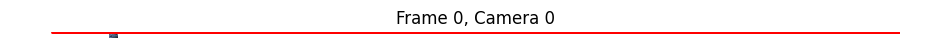

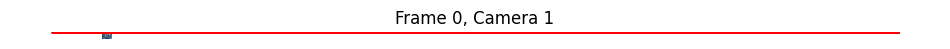

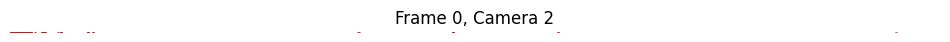

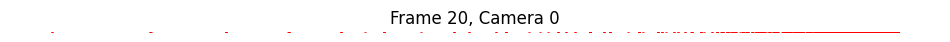

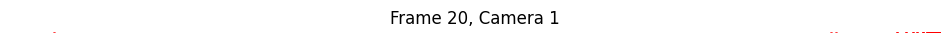

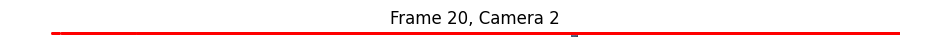

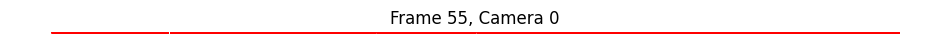

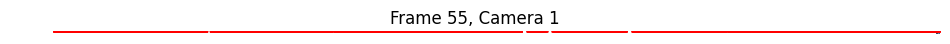

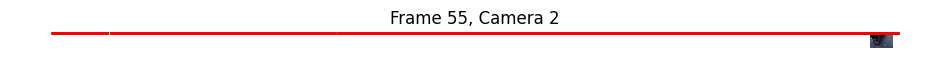

In [15]:


def read_lidar_points(filename):
    if not os.path.exists(filename):
        print(f"Error: LiDAR file not found: {filename}")
        return None
    lidar_data = np.fromfile(filename, dtype=np.float32).reshape(-1, 14)
    return lidar_data[:, :3]  # Return only x, y, z coordinates

def read_transformation_matrix(filepath):
    if not os.path.exists(filepath):
        print(f"Error: Transformation matrix file not found: {filepath}")
        return None
    data = np.loadtxt(filepath, dtype=np.float32)
    return data.reshape(4, 4)

def read_intrinsic_transformation_matrix(filepath):
    if not os.path.exists(filepath):
        print(f"Error: Intrinsic matrix file not found: {filepath}")
        return None
    data = np.loadtxt(filepath, dtype=np.float32)
    return data.reshape(3, 3)

def transform_points(points, transform_matrix):
    rotation = transform_matrix[:3, :3]
    translation = transform_matrix[:3, 3]
    return np.dot(points, rotation.T) + translation

def read_image(image_path):
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return None
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Failed to read image: {image_path}")
    return image

def concatenate_point_clouds(num_frames):
    all_points = []
    for i in range(num_frames):
        lidar_points = read_lidar_points(f"lidar/{i:03d}.bin")
        if lidar_points is None:
            continue
        ego2world = read_transformation_matrix(f"ego2world/{i:03d}.txt")
        if ego2world is None:
            continue
        transformed_points = transform_points(lidar_points, ego2world)
        all_points.append(transformed_points)
    return np.vstack(all_points) if all_points else None

def world_to_ego(points, frame_num):
    ego2world = read_transformation_matrix(f"ego2world/{frame_num:03d}.txt")
    if ego2world is None:
        return None
    world2ego = np.linalg.inv(ego2world)
    return transform_points(points, world2ego)

def ego_to_camera(points, cam_id):
    cam2ego = read_transformation_matrix(f"cam2ego/{cam_id:01d}.txt")
    if cam2ego is None:
        return None
    ego2cam = np.linalg.inv(cam2ego)
    return transform_points(points, ego2cam)

def project_to_image(points, cam_id):
    intrinsics = read_intrinsic_transformation_matrix(f"intrinsics/{cam_id:01d}.txt")
    if intrinsics is None:
        return None
    fx, fy, cx, cy = intrinsics[0, 0], intrinsics[1, 1], intrinsics[0, 2], intrinsics[1, 2]
    
    # Filter points in front of the camera
    points = points[points[:, 2] > 0]
    
    # Project 3D points to 2D
    points_2d = np.column_stack([
        fx * points[:, 0] / points[:, 2] + cx,
        fy * points[:, 1] / points[:, 2] + cy
    ])
    
    return points_2d

def overlay_points_on_image(image, points_2d, title):
    if image is None or points_2d is None:
        print(f"Error: Cannot overlay points on image for {title}")
        return
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.scatter(points_2d[:, 0], points_2d[:, 1], s=1, c='red', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

def main():
    num_frames = 56  # Total number of frames
    frames_to_process = [0, 20, 55]
    camera_ids = [0, 1, 2]
    
    # Concatenate all point clouds
    all_points = concatenate_point_clouds(num_frames)
    if all_points is None:
        print("Error: Failed to concatenate point clouds")
        return
    
    # Randomly sample points for better visualization
    sampled_points = all_points[np.random.choice(all_points.shape[0], 100000, replace=False)]
    
    for frame in frames_to_process:
        for cam_id in camera_ids:
            # Transform points to ego frame
            points_ego = world_to_ego(sampled_points, frame)
            if points_ego is None:
                continue
            
            # Transform points to camera frame
            points_cam = ego_to_camera(points_ego, cam_id)
            if points_cam is None:
                continue
            
            # Project points to image plane
            points_2d = project_to_image(points_cam, cam_id)
            if points_2d is None:
                continue
            
            # Read the corresponding image
            image = read_image(f"images/{frame:03d}_{cam_id:01d}.jpg")
            if image is None:
                continue
            
            # Overlay points on the image
            overlay_points_on_image(image, points_2d, f"Frame {frame}, Camera {cam_id}")

if __name__ == "__main__":
    main()

## Bonus

### `Task 3`. Compute Depth Image from Projected Point Cloud in camera frame (5 points)

**Instructions:**

Using the projected point clouds to camera frame from task 2, visualize the depth image by considering only the z-coordinate of the projected points in the camera frame.

Visualization: Display the depth image for each of the 3 cameras at timesteps `0, 20, and 55` alongside the corresponding RGB image.

In [17]:
##############################################################################
# TODO: TASK 3
##############################################################################

#### Note: You might be asked to show the above results for different timesteps and from one of the 3 cameras during evaluation/viva.

# Q2: Various Representations for Rotations and Gimbal lock (15 points)


#### 2.1 Euler angles (2.5 points)

a. Write a function that returns a rotation matrix given the angles (𝛼, 𝛽, 𝛾) = (2π/5, π/18, π/6) in radians (X-Y-Z). Do not use inbuilt functions.

b. Solve for angles using fsolve from scipy for three initializations of your choice and compare.
$$M(\alpha , \beta ,\gamma)=\left[\begin{array}{rrr}0.26200263 & -0.19674724 &  0.944799  \\0.21984631 &  0.96542533  & 0.14007684 \\
   -0.93969262 & 0.17101007 & 0.29619813\end{array}\right] 
$$

In [34]:
##############################################################################
# TODO: Do tasks described in 2.1 (a)

def rotation_matrix_xyz(alpha, beta, gamma):
    # Rotation matrix around X-axis
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha), np.cos(alpha)]
    ])

    # Rotation matrix around Y-axis
    R_y = np.array([
        [np.cos(beta), 0, np.sin(beta)],
        [0, 1, 0],
        [-np.sin(beta), 0, np.cos(beta)]
    ])

    # Rotation matrix around Z-axis
    R_z = np.array([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix (Rz * Ry * Rx)
    R = R_z @ R_y @ R_x

    return R

# Given angles in radians
alpha = 2 * np.pi / 5
beta = np.pi / 18
gamma = np.pi / 6

# Compute the rotation matrix
R = rotation_matrix_xyz(alpha, beta, gamma)
print("Rotation Matrix R:")
print(R)


Rotation Matrix R:
[[ 0.85286853 -0.01148507  0.52199939]
 [ 0.49240388  0.35019118 -0.79680898]
 [-0.17364818  0.93660783  0.30432233]]


#### 2.2 Equivalent angle–axis representation (2.5 points) 

 Write a function to convert equivalent angle–axis representation (with a general axis and angle) to matrix form and vice versa. \
Try it for $\theta = \pi/6$ and axis $K= [1, 2, 3]^T $

In [ ]:
##############################################################################
# TODO: Do tasks described in 2.2 
##############################################################################


#### 2.3 Gimbal lock (5 points)

Show an example where a Gimbal lock occurs and visualize the Gimbal lock on the given point cloud, data/toothless.ply. You have to show the above by animation (rotation along each axis one by one).

**Hint:** 
Create 3 disks perpendicular to each other representing axes for local frame of object. Show that in certain configuration, due to use of Euler angles we can lose a degree of freedom. 

Use Open3D's non-blocking visualization and discretize the rotation to simulate the animation. For example, if you want to rotate by 20° around a particular axis, do so in increments of 5° 4 times to make it look like an animation.

In [ ]:
##############################################################################
# TODO: Do tasks described in 2.3
##############################################################################


#### 2.4: Quaternions (5 points)

a. Convert a rotation matrix to quaternion and vice versa. Do not use inbuilt libraries for this question.

b. Perform matrix multiplication of two 3×3 rotation matrices and perform the same transformation in the quaternion space. Verify if the final transformation obtained in both cases is the same.

c. Try to interpolate any given model between two rotation matrices and visualize!

In [2]:
##############################################################################
# TODO: Do tasks described in 2.4 (a)
##############################################################################

In [3]:
##############################################################################
# TODO: Do tasks described in 2.4 (b)
##############################################################################

In [4]:
##############################################################################
# TODO: Do tasks described in 2.4 (c)
##############################################################################

# Q3: Interpolation between transformations (15 points)

Given 2 random transformation matrices, interpolate the given point cloud **toothless.ply** from `T2` to `T1` and visualize it.

We will use the `generateTransformation()` function to generate a random Transformation matrix. You can write your own `generateTransformation()` function for testing, but we will replace it with our own so make sure that your code works for general cases.

Ensure that your visualization shows the starting and ending configurations during interpolation.

Your final output should look something like this:
![Visualization](./out.gif)

In [2]:
def generate_transformation():
    # Random rotation matrix (3x3)
    theta = np.random.uniform(0, 2 * np.pi)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    
    # Random translation vector (3x1)
    translation_vector = np.random.uniform(-10, 10, size=(3,))
    
    # Combine rotation and translation into a 4x4 transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation_vector
    
    return transformation_matrix

MovieWriter imagemagick unavailable; using Pillow instead.


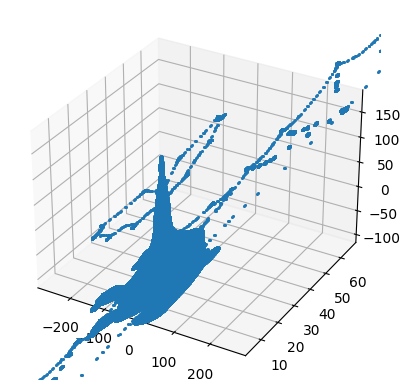

In [4]:
def generate_transformation():
    # Random rotation matrix (3x3)
    theta = np.random.uniform(0, 2 * np.pi)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    
    # Random translation vector (3x1)
    translation_vector = np.random.uniform(-10, 10, size=(3,))
    
    # Combine rotation and translation into a 4x4 transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation_vector
    
    return transformation_matrix

def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    return np.asarray(pcd.points)

def interpolate_transformation(T1, T2, alpha):
    return np.linalg.inv(T2) @ (alpha * T1 @ T2)

def apply_transformation(points, transformation):
    homogeneous_points = np.hstack((points, np.ones((points.shape[0], 1))))
    transformed_points = homogeneous_points @ transformation.T
    return transformed_points[:, :3]

def update_plot(num, points, line):
    alpha = num / num_steps
    T_interp = interpolate_transformation(T1, T2, alpha)
    transformed_points = apply_transformation(points, T_interp)
    line.set_data(transformed_points[:, 0], transformed_points[:, 1])
    line.set_3d_properties(transformed_points[:, 2])
    return line,

# Generate random transformation matrices
T1 = generate_transformation()
T2 = generate_transformation()

# Load the point cloud
points = load_point_cloud('toothless.ply')

# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot([], [], [], 'o', markersize=1)

# Set axis limits (optional, adjust as needed)
ax.set_xlim([points[:, 0].min(), points[:, 0].max()])
ax.set_ylim([points[:, 1].min(), points[:, 1].max()])
ax.set_zlim([points[:, 2].min(), points[:, 2].max()])

# Animation parameters
num_steps = 50
ani = animation.FuncAnimation(fig, update_plot, frames=num_steps + 1, fargs=(points, line), interval=100)

# Save the animation
ani.save('transformation_interpolation.gif', writer='imagemagick')

plt.show()


## Bonus (5 points)

In [20]:
##############################################################################
# TODO: Implement the above question using spherical linear interpolation (slerp)
##############################################################################

#### References: https://en.wikipedia.org/wiki/Slerp